In [1]:
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
import random

In [2]:
class EnergyEnv(gym.Env):
    def __init__(self):
        super(EnergyEnv, self).__init__()

        # Action space: 0 - Use solar, 1 - Store in battery, 2 - Draw from battery, 3 - Draw from grid
        self.action_space = spaces.Discrete(4)

        # Observation space: [battery_level, solar_energy, load]
        self.observation_space = spaces.Box(low=np.array([1000, 0, 0]), high=np.array([10000, 3000, 1000]), dtype=np.float32)

        potental_number_of_days_without_solar = 1

        self.solar_energy = {
            'hour0': 0 * 1000 * potental_number_of_days_without_solar, 
            'hour1': 0 * 1000 * potental_number_of_days_without_solar, 
            'hour2': 0 * 1000 * potental_number_of_days_without_solar, 
            'hour3': 0 * 1000 * potental_number_of_days_without_solar, 
            'hour4': 0 * 1000 * potental_number_of_days_without_solar, 
            'hour5': 0 * 1000 * potental_number_of_days_without_solar, 
            'hour6': 0.15 * 1000 * potental_number_of_days_without_solar, 
            'hour7': 0.4 * 1000 * potental_number_of_days_without_solar, 
            'hour8': 0.6 * 1000 * potental_number_of_days_without_solar, 
            'hour9': 0.8 * 1000 * potental_number_of_days_without_solar, 
            'hour10': 0.9 * 1000 * potental_number_of_days_without_solar, 
            'hour11': 0.96 * 1000 * potental_number_of_days_without_solar, 
            'hour12': 0.98 * 1000 * potental_number_of_days_without_solar, 
            'hour13': 0.9 * 1000 * potental_number_of_days_without_solar, 
            'hour14': 0.75 * 1000 * potental_number_of_days_without_solar, 
            'hour15': 0.58 * 1000 * potental_number_of_days_without_solar, 
            'hour16': 0.37 * 1000 * potental_number_of_days_without_solar, 
            'hour17': 0.14 * 1000 * potental_number_of_days_without_solar, 
            'hour18': 0 * 1000 * potental_number_of_days_without_solar, 
            'hour19': 0 * 1000 * potental_number_of_days_without_solar, 
            'hour20': 0 * 1000 * potental_number_of_days_without_solar, 
            'hour21': 0 * 1000 * potental_number_of_days_without_solar, 
            'hour22': 0 * 1000 * potental_number_of_days_without_solar, 
            'hour23': 0 * 1000 * potental_number_of_days_without_solar
        }

        self.load = {
            'hour0': 0.08 * 1000, 'hour1': 0.07 * 1000, 'hour2': 0.07 * 1000, 'hour3': 0.07 * 1000, 
            'hour4': 0.25 * 1000, 'hour5': 0.37 * 1000, 'hour6': 0.41 * 1000, 'hour7': 0.37 * 1000, 
            'hour8': 0.3 * 1000, 'hour9': 0.31 * 1000, 'hour10': 0.37 * 1000, 'hour11': 0.41 * 1000, 
            'hour12': 0.53 * 1000, 'hour13': 0.4 * 1000, 'hour14': 0.34 * 1000, 'hour15': 0.33 * 1000, 
            'hour16': 0.34 * 1000, 'hour17': 0.5 * 1000, 'hour18': 0.9 * 1000, 'hour19': 0.75 * 1000, 
            'hour20': 0.53 * 1000, 'hour21': 0.37 * 1000, 'hour22': 0.17 * 1000, 'hour23': 0.12 * 1000
        }

        self.battery_capacity = 10 * 1000  # Wh
        self.min_battery = 1 * 1000        # Minimum charge 10%
        self.max_battery = 10 * 1000       # Full charge
        
        # Set the initial hour, battery level, and grid usage
        self.current_hour = 0 
        self.battery_level = 2.35 * 1000  # Starting battery level in Wh
        
        self.grid_usage = 0  # Tracking how much energy is used from the grid
        
        self.battery_charge_and_discharge_rate = 5 * 1000  # Wh

    def reset(self):
        # Resetting environment to initial state
        self.current_hour = 0
        self.grid_usage = 0
        self.battery_level = 2.35 * 1000
        
        return np.array([self.battery_level, self.solar_energy['hour0'], self.load['hour0']], dtype=np.float32)

    def step(self, action):
        # Get solar energy and load for the current hour
        solar_energy = self.solar_energy[f'hour{self.current_hour}']
        load = self.load[f'hour{self.current_hour}']

        reward = 0
        grid_usage = 0
        demand_met = False
        surplus = 0

        # Action 0: Use solar energy to meet load demand
        if action == 0:
            if solar_energy >= load: # If demand is met
                wastage = solar_energy - load
                self.grid_usage += 0 # Do not draw from grid
                reward = load - wastage # Positive reward for meeting the load and not drawing from grid

            else: # If demand is not met
                load_deficit = load - solar_energy 
                self.grid_usage += load_deficit # Take energy deficit from grid
                self.battery_level += 0 # No surplus to save
                reward = -load_deficit # Negative reward for drawing energy from the grid

        # Action 1: Store in battery
        elif action == 1:
            if (self.battery_level + solar_energy) >= self.max_battery: # If charging exceeds battery capacity
                wastage = (self.battery_level + solar_energy) - self.max_battery 
                stored_energy = self.max_battery - self.battery_level
                self.battery_level = self.max_battery # Battery is full
                self.grid_usage += load
                reward = -load - wastage + stored_energy


            else: # If charging does not exceed battery capacity
                self.battery_level += solar_energy # Charge the battery
                stored_energy = solar_energy
                self.grid_usage += load # Grid carries the load when battery is charging
                reward = -load + stored_energy# Negative reward for drawing energy from the grid

        # Action 2: Draw from battery
        elif action == 2:
            if (self.battery_level - load) < self.min_battery: # If drawing from the battery drains it below min capacity
                if self.battery_level > self.min_battery: # Battery has some power to spare
                    available_battery_energy = self.battery_level - self.min_battery 
                    self.battery_level = self.min_battery 
                    self.grid_usage += load - available_battery_energy 
                    wastage = solar_energy
                    reward = -(load - available_battery_energy) - wastage # Negative reward for drawing energy from the grid
                else: # If the battery has no energy to spare
                    self.battery_level = self.min_battery 
                    self.grid_usage += load 
                    wastage = solar_energy
                    reward = -load - wastage # Negative reward for drawing energy from the grid
            else: # If drawing from the battery does not drain it
                self.battery_level -= load # Simply discharge
                self.grid_usage += 0 # Do not draw from grid
                wastage = solar_energy
                reward = load - wastage  # Positive reward for not drawing energy from the grid

        # Action 3: Draw from grid
        elif action == 3:
            self.battery_level -= 0 # Nothing happens to the battery
            self.grid_usage += load # Grid carries the load
            wastage = solar_energy
            punish_factor = 1 # Drawing energy directly from the grid is discouraged more than any other option
            reward = -load * punish_factor - wastage # Negative reward for drawing energy from the grid
            
        # Move to the next hour in the environment
        self.current_hour += 1
        done = self.current_hour == 24
        if self.current_hour == 24: # Reset after a day passes
            self.current_hour = 0

        # Observation at the next time step
        next_observation = np.array([self.battery_level, self.solar_energy[f'hour{self.current_hour}'], self.load[f'hour{self.current_hour}']], dtype=np.float32)

        

        return next_observation, reward, done, {}

    def render(self, mode='human'):
        print(f'Hour: {self.current_hour}, Battery Level: {self.battery_level}, Grid Usage: {self.grid_usage}')


In [3]:
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
import random

class SARSAAgent:
    def __init__(self, env, learning_rate=0.01, discount_factor=0.9995, epsilon=1.0, epsilon_decay=0.9995, epsilon_min=0.01):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = np.zeros((100, 100, 100, env.action_space.n))  # Q-table initialization
        self.best_actions = []  # To store actions of the best episode
    
    def discretize(self, state):
        """Discretize the state space into manageable buckets."""
        battery, solar, load = state
        battery_idx = min(int((battery / self.env.battery_capacity) * 100), 99)
        solar_idx = min(int((solar / 3000) * 100), 99)
        load_idx = min(int((load / 1000) * 100), 99)
        return (battery_idx, solar_idx, load_idx)
    
    def choose_action(self, state):
        """Choose the next action using an epsilon-greedy approach."""
        if np.random.rand() <= self.epsilon:
            return self.env.action_space.sample()  # Explore: Random action
        else:
            battery_idx, solar_idx, load_idx = self.discretize(state)
            return np.argmax(self.q_table[battery_idx, solar_idx, load_idx])  # Exploit: Choose best action
    
    def update_q_value(self, state, action, reward, next_state, next_action):
        """Update Q-table using SARSA formula."""
        battery_idx, solar_idx, load_idx = self.discretize(state)
        next_battery_idx, next_solar_idx, next_load_idx = self.discretize(next_state)
        td_target = reward + self.discount_factor * self.q_table[next_battery_idx, next_solar_idx, next_load_idx, next_action]
        td_error = td_target - self.q_table[battery_idx, solar_idx, load_idx, action]
        self.q_table[battery_idx, solar_idx, load_idx, action] += self.learning_rate * td_error
    
    def train(self, episodes=10000, max_steps=24):
        """Train the SARSA agent."""
        rewards = []
        grid_usage = []
        best_episode_reward = float('-inf')  # Initialize the best reward as negative infinity
        best_episode_actions = []

        for episode in range(episodes):
            state = self.env.reset()
            action = self.choose_action(state)  # Choose the initial action using epsilon-greedy
            total_reward = 0
            total_grid_usage = 0
            actions = []  # Track actions for this episode

            for step in range(max_steps):
                next_state, reward, done, info = self.env.step(action)
                next_action = self.choose_action(next_state)  # Choose the next action

                actions.append(action)  # Track actions taken in this episode
                self.update_q_value(state, action, reward, next_state, next_action)

                state = next_state
                action = next_action  # Move to the next state and action
                total_reward += reward
                total_grid_usage += info.get('grid_usage', 0)

                if done:
                    break

            rewards.append(total_reward)
            grid_usage.append(total_grid_usage)
            
            # Check if this is the best episode so far based on reward
            if total_reward > best_episode_reward:
                best_episode_reward = total_reward
                best_episode_actions = actions  # Save the best actions
            
            # Decay epsilon after each episode to reduce exploration over time
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

            if episode % 1 == 0:
                print(f'Episode {episode}, Total Reward: {total_reward}, Grid Usage: {total_grid_usage}, Epsilon: {self.epsilon}')
        
        self.best_actions = best_episode_actions  # Store the best action sequence
        return rewards, grid_usage

    def get_action_descriptions(self, actions):
        """Translate actions into human-readable descriptions."""
        action_descriptions = []
        for action in actions:
            if action == 0:
                action_descriptions.append("Solar energy to house")
            elif action == 1:
                action_descriptions.append("Solar energy to battery")
            elif action == 2:
                action_descriptions.append("Draw energy from battery")
            elif action == 3:
                action_descriptions.append("Draw energy from the grid")
            else:
                action_descriptions.append("Unknown action")  # In case of an invalid action
        return action_descriptions






In [4]:

# Initialize custom energy environment
env = EnergyEnv()

# Initialize the SARSA agent
sarsa_agent = SARSAAgent(env, learning_rate=0.1, discount_factor=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01)

# Train the agent and get rewards and grid usage data
rewards, grid_usage = sarsa_agent.train(episodes=2000)


C:\Users\Revaldo Nkwinika\anaconda3\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Episode 0, Total Reward: -5730.0, Grid Usage: 0, Epsilon: 0.995
Episode 1, Total Reward: -10840.0, Grid Usage: 0, Epsilon: 0.990025
Episode 2, Total Reward: -5910.0, Grid Usage: 0, Epsilon: 0.985074875
Episode 3, Total Reward: -8410.0, Grid Usage: 0, Epsilon: 0.9801495006250001
Episode 4, Total Reward: -4460.0, Grid Usage: 0, Epsilon: 0.9752487531218751
Episode 5, Total Reward: -3610.0, Grid Usage: 0, Epsilon: 0.9703725093562657
Episode 6, Total Reward: -1530.0, Grid Usage: 0, Epsilon: 0.9655206468094844
Episode 7, Total Reward: -3770.0, Grid Usage: 0, Epsilon: 0.960693043575437
Episode 8, Total Reward: -5530.0, Grid Usage: 0, Epsilon: 0.9558895783575597
Episode 9, Total Reward: -5640.0, Grid Usage: 0, Epsilon: 0.9511101304657719
Episode 10, Total Reward: -1910.0, Grid Usage: 0, Epsilon: 0.946354579813443
Episode 11, Total Reward: -7330.0, Grid Usage: 0, Epsilon: 0.9416228069143757
Episode 12, Total Reward: -9470.0, Grid Usage: 0, Epsilon: 0.9369146928798039
Episode 13, Total Reward: -

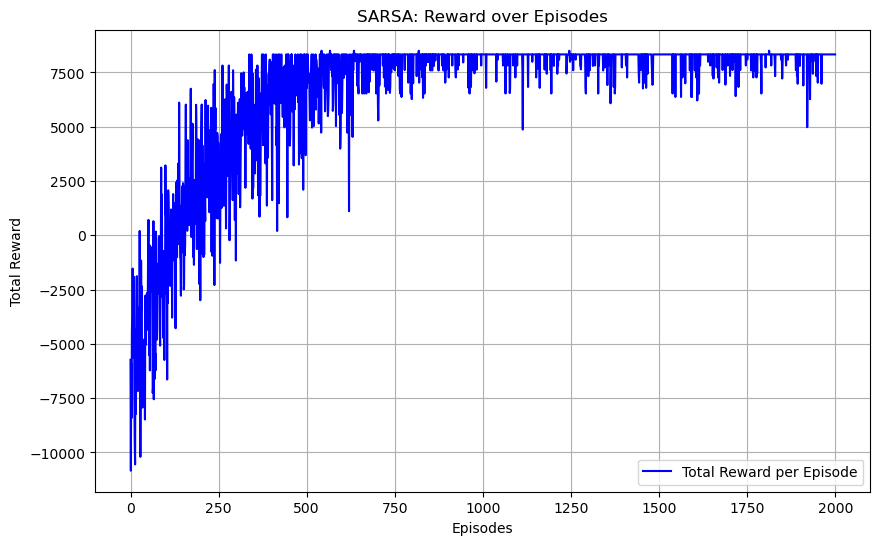

In [5]:
# Visualization for Rewards
def plot_rewards(rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards, label="Total Reward per Episode", color='blue')
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.title("SARSA: Reward over Episodes")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_rewards(rewards)

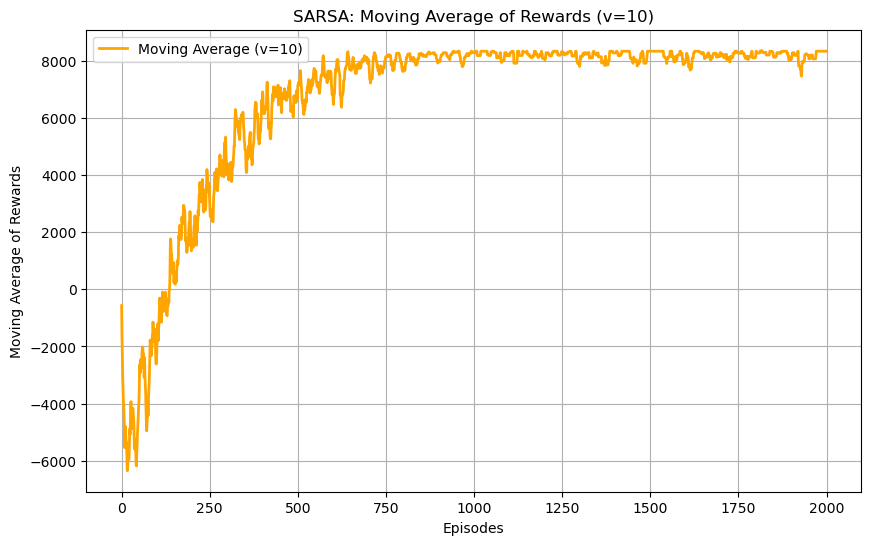

In [6]:

def plot_moving_average(rewards, v=10):
    """Plot the moving average of rewards over episodes."""
    # Calculate the moving average
    moving_avg = []
    for i in range(len(rewards)):
        # Get the slice of the previous v episodes including the current one
        relevant_rewards = rewards[max(0, i - v + 1):i + 1]
        # Pad with zeros if there are fewer than v episodes
        while len(relevant_rewards) < v:
            relevant_rewards.insert(0, 0)  
        # Compute the average
        moving_avg.append(np.mean(relevant_rewards))
    
    # Plotting the moving average
    plt.figure(figsize=(10, 6))
    plt.plot(moving_avg, label=f"Moving Average (v={v})", color='orange', linewidth=2)
    plt.xlabel("Episodes")
    plt.ylabel("Moving Average of Rewards")
    plt.title(f"SARSA: Moving Average of Rewards (v={v})")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_moving_average(rewards)


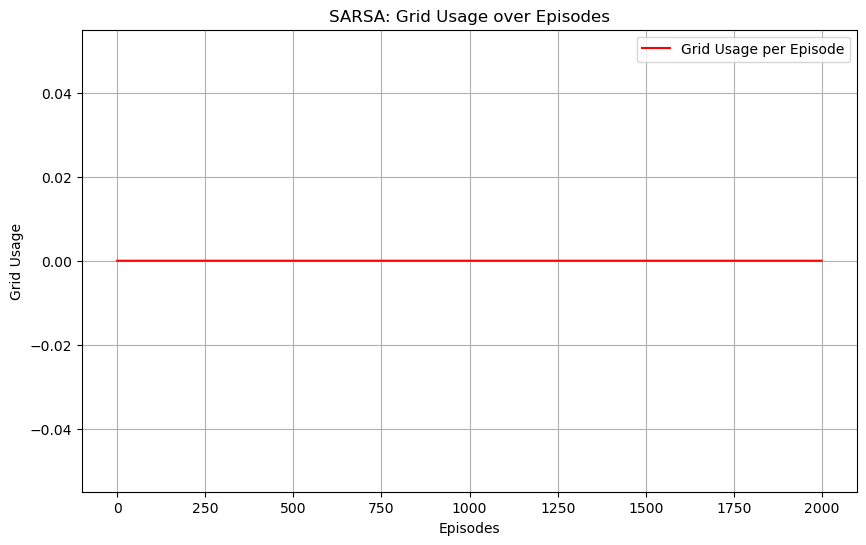

In [7]:
# Visualization for Grid Usage
def plot_grid_usage(grid_usage):
    plt.figure(figsize=(10, 6))
    plt.plot(grid_usage, label="Grid Usage per Episode", color='red')
    plt.xlabel("Episodes")
    plt.ylabel("Grid Usage")
    plt.title("SARSA: Grid Usage over Episodes")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_grid_usage(grid_usage)



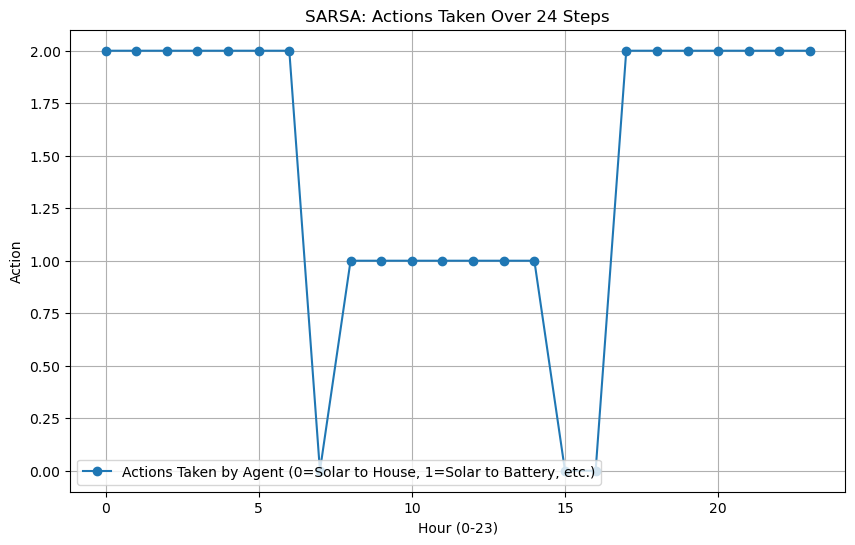

In [8]:

# Visualize the actions over one episode
def visualize_policy(sarsa_agent, state):
    actions = []
    state = env.reset()
    
    for _ in range(24):  # 24 hours
        action = sarsa_agent.choose_action(state)
        actions.append(action)
        next_state, _, _, _ = env.step(action)
        state = next_state
    
    plt.figure(figsize=(10, 6))
    plt.plot(actions, label="Actions Taken by Agent (0=Solar to House, 1=Solar to Battery, etc.)", marker='o')
    plt.xlabel("Hour (0-23)")
    plt.ylabel("Action")
    plt.title("SARSA: Actions Taken Over 24 Steps")
    plt.legend()
    plt.grid(True)
    plt.show()

# Test the agent and visualize actions over 24 hours
visualize_policy(sarsa_agent, env.reset())



In [9]:
# Translate best actions to human-readable descriptions
best_action_descriptions = sarsa_agent.get_action_descriptions(sarsa_agent.best_actions)

# Display the best actions in words
for i, description in enumerate(best_action_descriptions):
    print(f"Hour {i}: {description}")


Hour 0: Draw energy from battery
Hour 1: Draw energy from battery
Hour 2: Draw energy from battery
Hour 3: Draw energy from battery
Hour 4: Draw energy from battery
Hour 5: Draw energy from battery
Hour 6: Draw energy from battery
Hour 7: Solar energy to house
Hour 8: Solar energy to battery
Hour 9: Solar energy to battery
Hour 10: Solar energy to battery
Hour 11: Solar energy to battery
Hour 12: Solar energy to battery
Hour 13: Solar energy to battery
Hour 14: Solar energy to battery
Hour 15: Solar energy to battery
Hour 16: Solar energy to house
Hour 17: Draw energy from battery
Hour 18: Draw energy from battery
Hour 19: Draw energy from battery
Hour 20: Draw energy from battery
Hour 21: Draw energy from battery
Hour 22: Draw energy from battery
Hour 23: Draw energy from battery


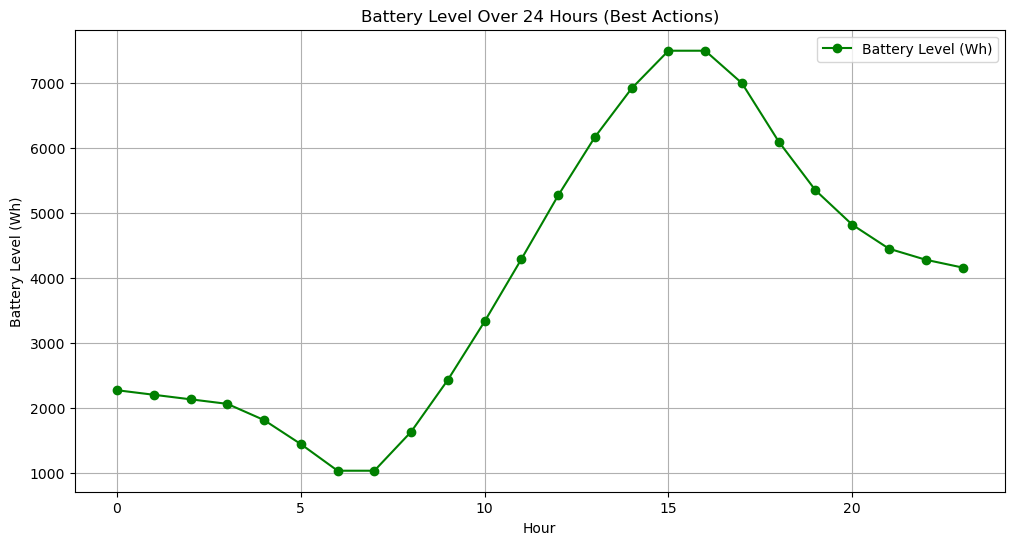

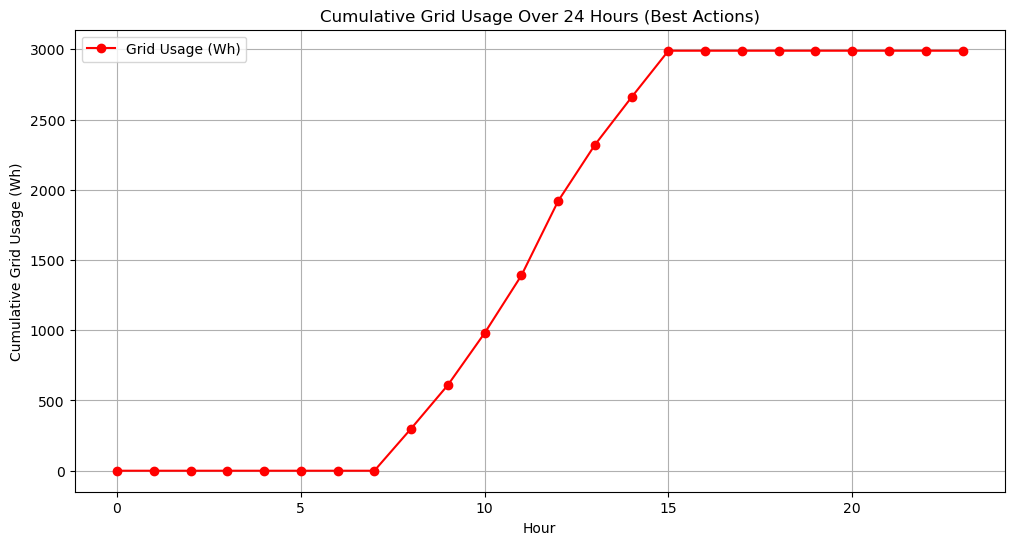

In [10]:
## Visualization and tracking functions 
# Track battery level and grid usage for 24 hours based on the best actions
def track_battery_and_grid_usage(env, best_actions):
    battery_levels = []  # Store battery level at each hour
    grid_usages = []     # Store grid usage at each hour

    state = env.reset()  # Reset environment to initial state
    for hour, action in enumerate(best_actions):
        # Take action and collect relevant data
        next_state, reward, done, info = env.step(action)
        
        # Record battery level and cumulative grid usage after each step
        battery_levels.append(env.battery_level)
        grid_usages.append(env.grid_usage)
        
        # Update state to the next one
        state = next_state
        if done:
            break

    # Plot battery levels over 24 hours
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(battery_levels)), battery_levels, marker='o', color='green', label='Battery Level (Wh)')
    plt.xlabel('Hour')
    plt.ylabel('Battery Level (Wh)')
    plt.title('Battery Level Over 24 Hours (Best Actions)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot grid usage over 24 hours
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(grid_usages)), grid_usages, marker='o', color='red', label='Grid Usage (Wh)')
    plt.xlabel('Hour')
    plt.ylabel('Cumulative Grid Usage (Wh)')
    plt.title('Cumulative Grid Usage Over 24 Hours (Best Actions)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to visualize battery level and grid usage for 24 hours
track_battery_and_grid_usage(env, sarsa_agent.best_actions)




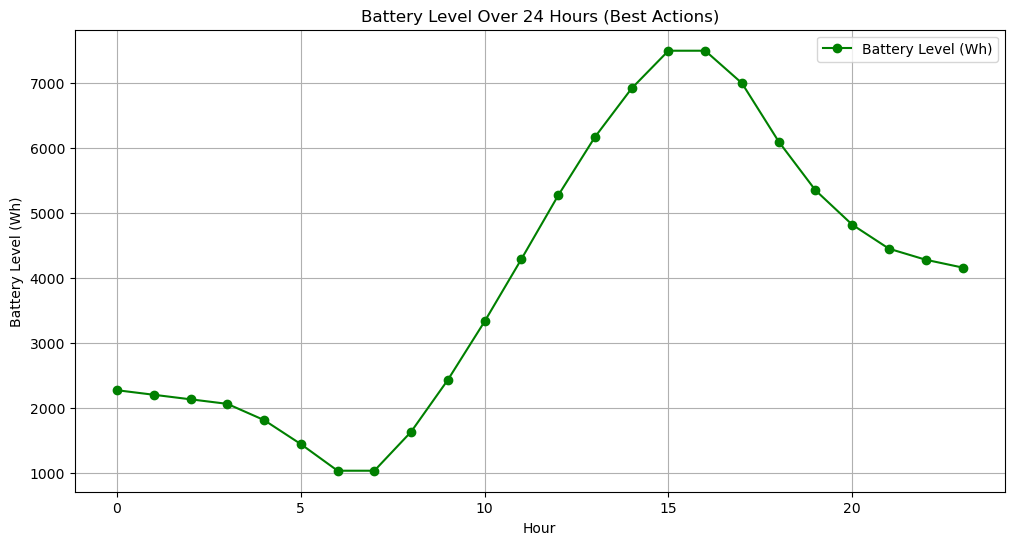

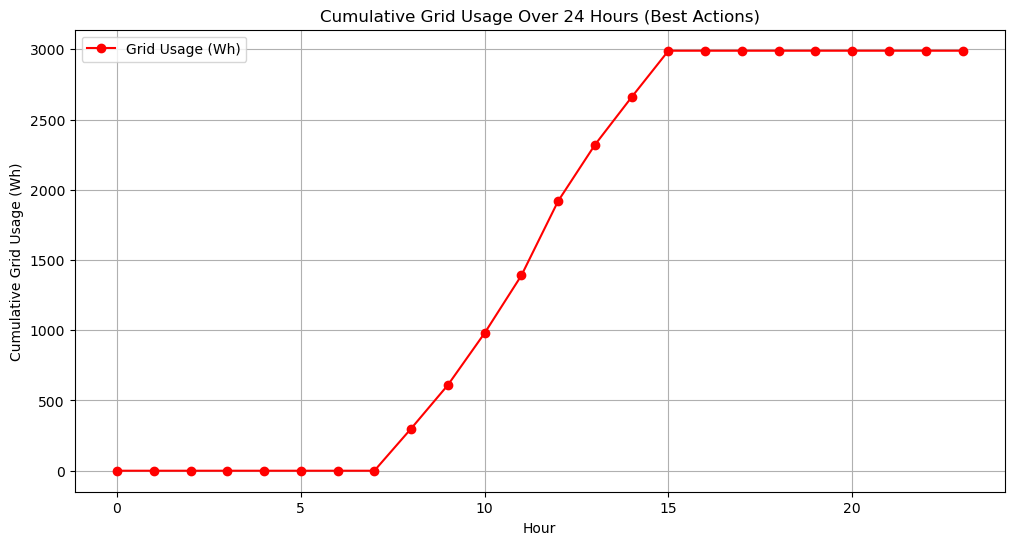

In [11]:


# Call the function to visualize battery level and grid usage for 24 hours
track_battery_and_grid_usage(env, sarsa_agent.best_actions)